<a href="https://colab.research.google.com/github/leungjch/drug_VAE/blob/master/drug_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://pubs.acs.org/doi/full/10.1021/acs.jcim.8b00751?src=recsys

# https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb?flush_cache=true
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [0]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install sklearn

--2020-02-19 23:18:48--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   163MB/s    in 0.4s    

2020-02-19 23:18:49 (163 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
  

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [0]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
data = pd.read_pickle("drive/My Drive/drugVAE/pickleData.pkl")

In [0]:
data = pd.read_csv("drive/My Drive/2m_moses.csv")
# cut out spaces
print(data.SMILES[76])

Cc1csc(=NS(=O)(=O)c2ccc(N)cc2)[nH]1


In [0]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
from keras.models import Sequential
from keras.layers import Convolution2D, Convolution1D
from keras.layers import Flatten
from keras.layers import GRU
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras import objectives
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist

from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
from rdkit import Chem
from rdkit.Chem import Draw

import tensorflow as tf
from keras.models import load_model

import numpy as np
from scipy.stats import norm
from sklearn import manifold
from sklearn.decomposition import PCA



ModuleNotFoundError: ignored

In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15448377936306497359, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 913635908198395643
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9455955983104025800
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10060898456167430125
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
# One hot encoding

SMILE_CHARSET = [' ',
                  '#', '%', '(', ')', '+', '-', '.', '/',
                  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  '=', '@',
                  'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                  'R', 'S', 'T', 'V', 'X', 'Z',
                  '[', '\\', ']',
                  'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                  't', 'u']

# SMILE_CHARSET = [
#     ' ', '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
#     '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
#     'o', 'n', 'p', 's', 'r'
# ]
SMILE_CHARSET = [
    '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
    '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
    'o', 'n', 'p', 's', 'r'
]
print(len(SMILE_CHARSET))
SMILE_CHARSET = ''.join(SMILE_CHARSET)
print(SMILE_CHARSET)
# print(SMILE_CHARSET)
# each molecule is represented as a 35x109 matrix

MAX_MOLSIZE = max(data['SMILES'].str.len())
print(MAX_MOLSIZE)
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
# print(SMILE_to_index)

smiles_onehot = []
n = 0
for smile in data['SMILES'][0:50000]:

    SMILE_encoded = [SMILE_to_index[char] for char in smile]
    # print(SMILE_encoded)
    # one hot encoded
    onehot_encoded = list()
    for value in SMILE_encoded:
#         print(len(SMILE_CHARSET))
        letter = [0 for _ in range(len(SMILE_CHARSET))]
        letter[value] = 1
        onehot_encoded.append(letter)

    # columns are charset, rows are molecule index
    df = pd.DataFrame(onehot_encoded)
    df['PADDING'] = 0
    # PADDING: create an empty dataframe of padding MAX_MOLSIZE-moleculeSize
    if len(data.iloc[0].SMILES) < MAX_MOLSIZE:
        # add padding
        temp = pd.DataFrame(np.zeros((MAX_MOLSIZE- len(smile), len(df.columns)-1)))
        temp['PADDING'] = 1
        df = df.append(temp, ignore_index=True)
    smiles_onehot.append(df)
    if (n % 10000 == 0):
        print(n)
    
    n+=1
#pprint(df)
# # invert encoding
# inverted = index_to_SMILE[np.argmax(onehot_encoded[0])]
# # print(inverted)
# pickle usage

34
#)(+-/13254768=@CBFIHONS[]\clonpsr


NameError: ignored

In [0]:
npData = np.stack(smiles_onehot)
np.save("drive/My Drive/npData_50k.npy", npData)

In [0]:
npData = np.load("drive/My Drive/npData_50k.npy")
print(npData.shape)

(50000, 52, 35)


In [0]:
# optional: cut data
data = data[0:10000]

In [0]:
# x_train = np.array(npData[0:10000])
x_train = npData[0:40000]
x_test = npData[0:40000]

y_train = np.array(npData[40000:50000])
y_test = np.array(npData[40000:5000])
print(len(y_train))
# print(len(x_train))
# x_test = np.array(npData[0:10000])
# print(len(x_test))

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_test = x_test[0:5000]
# x_train = x_train[0:5000]
# plt.matshow(x_test[6].T)


10000


In [0]:
original_dim = (x_test.shape[1], x_test.shape[2])
# original_dim = (28, 28)

input_shape = (original_dim, )
intermediate_dim = 512
latent_dim = 256
batch_size = 32
epochs = 50
epsilon_std = 1.0
print(original_dim)
SMILE_CHARSET = [
    '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
    '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
    'o', 'n', 'p', 's', 'r'
]
max_length = len(SMILE_CHARSET)+1

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_vari = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_vari) * epsilon

lstm_dim = 64

K.clear_session()
# encoder: CNN
E_Input = Input(shape=(original_dim), name="encoder_input")
E_Conv0 = Convolution1D(9, 9, activation = 'relu', name='conv_1')(E_Input)
E_Conv1 = Convolution1D(9, 9, activation = 'relu', name='conv_2')(E_Conv0)
E_Conv2 = Convolution1D(10, 11, activation = 'relu', name='conv_3')(E_Conv1)

# E_G0 = GRU(200, return_sequences = True, name='gru_1')(E_Input)

E_F = Flatten(name='flatten_1')(E_Conv2)
E_Output = Dense(latent_dim, activation = 'relu', name='dense_1')(E_F)
# E_Output = Dense(435, activation = 'relu', name='dense_1')(E_F)

z_mu = Dense(latent_dim, name='z_mean')(E_Output)
z_log_var = Dense(latent_dim, name='z_log_var')(E_Output)
# z_mu_kl, z_log_var_kl = KLDivergenceLayer()([z_mu, z_log_var])
z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_var])

# z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

# eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim)))

# z_eps = Multiply()([z_sigma, eps])
# z = Add()([z_mu, z_eps])


# decoder: GRU
D_Input = Input(shape=(latent_dim,), name = "decoder_input") # Contains latents
#D_Input = Dense(latent_dim, name = 'decoder_dense', activation='relu')(D_Input)
D_RV = RepeatVector(x_train.shape[1], name='repeat_vector')(D_Input)
#D_D =  Dense(units= 435, name='latent_input', activation='relu')(D_Input)
D_G0 = GRU(501, return_sequences = True, name='gru_1')(D_RV)
D_G1 = GRU(501, return_sequences = True, name='gru_2')(D_G0)
D_G2 = GRU(501, return_sequences = True, name='gru_3')(D_G1)
D_Output = TimeDistributed(Dense(x_train.shape[2], activation='softmax'), name = 'decoded_mean')(D_G0)
#D_Output = Dense(original_dim, activation = 'sigmoid')(D_G2)

#Encoder = Model(E_Input, [z_mu, z_log_var, z], name="encoder")
Encoder = Model(E_Input, [z_mu, z_log_var, z], name="encoder")

Decoder = Model(D_Input, D_Output, name = "decoder")

# print("ein:", Encoder.input_shape)
# print("eout:", Encoder.output_shape)
# print("din:", Decoder.input_shape)
# print("dout:", Decoder.output_shape)
x_pred = Decoder(Encoder(E_Input)[2])

def vae_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mu) - K.exp(z_log_var), axis = -1)
    return xent_loss + kl_loss

vae = Model(inputs=[E_Input], outputs=x_pred)

from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=10, min_lr=0.000000001, verbose=1, epsilon=1e-5)
from keras.callbacks import ModelCheckpoint

filepath="drive/My Drive/vaemodels/train1/weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, h, rlr]

#opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(loss=vae_loss, optimizer='Adam', metrics = ['accuracy'])
plot_model(vae, to_file='encoder.png', show_shapes=False)
print(vae.summary())
# print(Decoder.summary())
# print(Encoder.summary())

vae.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                callbacks = [h,rlr, checkpoint],
                validation_data=(x_test, x_test))


(52, 35)


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 52, 35)            0         
_________________________________________________________________
encoder (Model)              [(None, 256), (None, 256) 202982    
_________________________________________________________________
decoder (Model)              (None, 52, 35)            1156844   
Total params: 1,359,826
Trainable params: 1,359,826
Non-trainable params: 0
_________________________________________________________________
None
Train on 40000 samples, validate on 40000 samples
Epoch 1/50
 3584/40000 [=>............................] - ETA: 2:27 - loss: 3.1052 - acc: 0.3727

KeyboardInterrupt: ignored

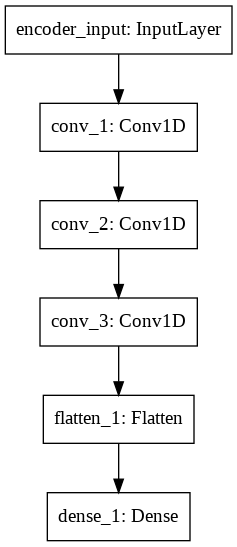

In [0]:
plot_model(Encoder.get_layer('encoder'))

In [0]:
# continue training
# save model

vae.save("drive/My Drive/vae.h5")
Encoder.save("drive/My Drive/encoder.h5")
Decoder.save("drive/My Drive/decoder.h5")


# loading model
# returns a compiled model
# identical to the previous one
# newVae  = load_model('/content/drive/My Drive/vaemodels/train5/weights-improvement-96-0.96.hdf5')


In [0]:
x_train.dtype

dtype('float64')

In [0]:
import keras.backend as K
K.clear_session()
tf.reset_default_graph() 
K.set_learning_phase(1) #set learning phase

original_dim = (x_test.shape[1], x_test.shape[2])
# original_dim = (28, 28)

input_shape = (original_dim, )
intermediate_dim = 512
latent_dim = 256
batch_size = 32
epochs = 50
epsilon_std = 1.0
print(original_dim)
SMILE_CHARSET = [
    '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
    '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
    'o', 'n', 'p', 's', 'r'
]
max_length = len(SMILE_CHARSET)+1

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_vari = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_vari) * epsilon

lstm_dim = 64

# encoder: CNN
E_Input = Input(shape=(original_dim), name="encoder_input")
E_Conv0 = Convolution1D(9, 9, activation = 'relu', name='conv_1')(E_Input)
E_Conv1 = Convolution1D(9, 9, activation = 'relu', name='conv_2')(E_Conv0)
E_Conv2 = Convolution1D(10, 11, activation = 'relu', name='conv_3')(E_Conv1)

# E_G0 = GRU(200, return_sequences = True, name='gru_1')(E_Input)

E_F = Flatten(name='flatten_1')(E_Conv2)
E_Output = Dense(latent_dim, activation = 'relu', name='dense_1')(E_F)
# E_Output = Dense(435, activation = 'relu', name='dense_1')(E_F)

z_mu = Dense(latent_dim, name='z_mean')(E_Output)
z_log_var = Dense(latent_dim, name='z_log_var')(E_Output)
# z_mu_kl, z_log_var_kl = KLDivergenceLayer()([z_mu, z_log_var])
z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_var])

# z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

# eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim)))

# z_eps = Multiply()([z_sigma, eps])
# z = Add()([z_mu, z_eps])

# decoder: GRU
D_Input = Input(shape=(latent_dim,), name = "decoder_input") # Contains latents
#D_Input = Dense(latent_dim, name = 'decoder_dense', activation='relu')(D_Input)
D_RV = RepeatVector(x_train.shape[1], name='repeat_vector')(D_Input)
#D_D =  Dense(units= 435, name='latent_input', activation='relu')(D_Input)
D_G0 = GRU(501, return_sequences = True, name='gru_1')(D_RV)
D_G1 = GRU(501, return_sequences = True, name='gru_2')(D_G0)
D_G2 = GRU(501, return_sequences = True, name='gru_3')(D_G1)
D_Output = TimeDistributed(Dense(x_train.shape[2], activation='softmax'), name = 'decoded_mean')(D_G0)
#D_Output = Dense(original_dim, activation = 'sigmoid')(D_G2)

#Encoder = Model(E_Input, [z_mu, z_log_var, z], name="encoder")
Encoder = Model(E_Input, [z_mu, z_log_var, z], name="encoder")

Decoder = Model(D_Input, D_Output, name = "decoder")

# print("ein:", Encoder.input_shape)
# print("eout:", Encoder.output_shape)
# print("din:", Decoder.input_shape)
# print("dout:", Decoder.output_shape)
x_pred = Decoder(Encoder(E_Input)[2])

def vae_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mu) - K.exp(z_log_var), axis = -1)
    return xent_loss + kl_loss
vae = Model(inputs=[E_Input], outputs=x_pred)
print(vae.summary())
vae  = load_model('drive/My Drive/vaemodels/train1/weights-improvement-84-0.98.hdf5', custom_objects={'vae_loss': vae_loss})
print(vae.summary())
# vae.evaluate(x_train[0:2],x_train[0:2])
vae.compile(loss=vae_loss, optimizer='Adam', metrics = ['accuracy'])
h = History()
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=2, min_lr=0.000000001, verbose=1, epsilon=1e-5)
from keras.callbacks import ModelCheckpoint

filepath="drive/My Drive/vaemodels/train2/weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, h, rlr]
print(x_train.shape)
# vae.evaluate(x_test[0:2], x_test[0:2])

vae.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                callbacks = callbacks_list,
                validation_data=(x_test, x_test))



Using TensorFlow backend.


NameError: ignored

In [0]:
import keras.backend as K
K.clear_session()
tf.reset_default_graph()
vae  = load_model('drive/My Drive/vaemodels/train1/weights-improvement-84-0.98.hdf5', custom_objects={'vae_loss': vae_loss})
plot_model(vae.get_layer('encoder'))
vae.get_layer('encoder').summary()

ValueError: ignored

In [0]:
print(K.eval(vae.optimizer.lr))

0.000125


In [0]:
# Get latent space

original_dim = (x_test.shape[1], x_test.shape[2])
# original_dim = (28, 28)

input_shape = (original_dim, )
intermediate_dim = 512
latent_dim = 1000


# build encoder
Encoder = Model(inputs=vae.input, outputs=vae.get_layer("encoder").get_output_at(-1))
x =Encoder.predict(x_test)[2]

# build decoder
Decoder = Model(inputs=vae.get_layer("decoder").get_layer('decoder_input').output, outputs=vae.get_layer("decoder").get_layer('decoded_mean').output)

decoded = Decoder.predict(x)


In [0]:
epochs = 100
batch_size =32

from keras.callbacks import History, ReduceLROnPlateau
K.clear_session()
tf.reset_default_graph()

vae  = load_model('drive/My Drive/vaemodels/train1/weights-improvement-84-0.98.hdf5', custom_objects={'vae_loss': vae_loss})
vae.compile(loss=vae_loss, optimizer='Adam', metrics = ['accuracy'])

# K.clear_session()
vae.get_layer('encoder').summary()
h = History()
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=2, min_lr=0.000000001, verbose=1, epsilon=1e-5)
from keras.callbacks import ModelCheckpoint

filepath="drive/My Drive/vaemodels/train2/weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, h, rlr]
print(x_train.shape)
# vae.evaluate(x_test[0:2], x_test[0:2])
# tf.reset_default_graph()

vae.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                callbacks = callbacks_list,
                validation_data=(x_test, x_test))


NameError: ignored

In [0]:
x_tr = x_train.reshape(x_train.shape[0], 52*36)
x_te = x_test.reshape(x_test.shape[0], 52*36)
print(x_tr.shape)

In [0]:
# Get latent space

original_dim = (x_test.shape[1], x_test.shape[2])
# original_dim = (28, 28)

input_shape = (original_dim, )
intermediate_dim = 512
latent_dim = 1000


# build encoder
Encoder = Model(inputs=vae.input, outputs=vae.get_layer("encoder").get_output_at(-1))
x =Encoder.predict(x_test)

# build decoder
Decoder = Model(inputs=vae.get_layer("decoder").get_layer('decoder_input').output, outputs=vae.get_layer("decoder").get_layer('decoded_mean').output)

decoded = Decoder.predict(x)


In [0]:
print(decoded.shape)

In [0]:

# out is one molecule
def outToSMILES(OUT):
  # SMILE_CHARSET = [' ',
  #                 '#', '%', '(', ')', '+', '-', '.', '/',
  #                 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
  #                 '=', '@',
  #                 'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
  #                 'R', 'S', 'T', 'V', 'X', 'Z',
  #                 '[', '\\', ']',
  #                 'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
  #                 't', 'u', '_']
  SMILE_CHARSET = [
      '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
      '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
      'o', 'n', 'p', 's', 'r','_']
  #print(len(SMILE_CHARSET))
  maxProbIndexes = (np.argmax(OUT, axis=1))
  #print(maxProbIndexes)
  
  smile = ""
  for i in range(len(maxProbIndexes)):

    smile += SMILE_CHARSET[maxProbIndexes[i]]
    
  return smile
#out = decoded_output[502]
np.set_printoptions(threshold=sys.maxsize)
n=0
c=0
# for decode in x:
#   cand = outToSMILES(decode)
#   #print(cand)
#   cand = str.replace(cand, "_", "")
#   m = Chem.MolFromSmiles(cand,sanitize=False)
#   if m is None:
#     c+=1
# print(c/len(x))
dec = Decoder.predict(x)

dec = dec[0:10000]

data['validMolecule']=0
count = 0
for n in range(len(dec)):
  #print(dec.shape)
  out =dec[n]
  #print(out)

  out1 = x_test[n]

  # # out = x_train[0]
  m1 = outToSMILES(out)
  m1 = str.replace(m1, "_", "")
  m2 = outToSMILES(out1)
  m2 = str.replace(m2, "_", "")
  #print(m1, "         ", m2)
  #m1 = outToSMILES(out1)
  mole1 = Chem.MolFromSmiles(m1)
  
  if mole1:
    #Draw.MolToMPL(mole1)
    count+=1
    data.loc[n,'validMolecule'] = 1


  # else:
  #   #print(m1, " is incorrect")
print(count)

NameError: ignored

In [0]:
def outToSMILES(OUT):
  # SMILE_CHARSET = [' ',
  #                 '#', '%', '(', ')', '+', '-', '.', '/',
  #                 '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
  #                 '=', '@',
  #                 'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
  #                 'R', 'S', 'T', 'V', 'X', 'Z',
  #                 '[', '\\', ']',
  #                 'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
  #                 't', 'u', '_']
  SMILE_CHARSET = [
      '#', ')', '(', '+', '-', '/', '1', '3', '2', '5', '4', '7', '6', '8',
      '=', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'S', '[', ']', '\\', 'c', 'l',
      'o', 'n', 'p', 's', 'r','_']
  #print(len(SMILE_CHARSET))
  maxProbIndexes = (np.argmax(OUT, axis=1))
  # print(maxProbIndexes)
  #print(maxProbIndexes)
  
  smile = ""
  for i in range(len(maxProbIndexes)):

    smile += SMILE_CHARSET[maxProbIndexes[i]]
    
  return smile

# print(x_decoded[0])
outToSMILES(x_decoded[0])

'olllllllllllllllllllllllllllllllllllllllllllllllllll'

In [0]:
# code for logp and QED

import rdkit.Chem.Crippen
from rdkit.Chem.Descriptors import qed
from rdkit.Chem import QED


mole1 = Chem.MolFromSmiles("Cc1nn(N)cc(C2N)c(OC)c2NN2CNc2cc(C)c1")
print("logp: ", rdkit.Chem.Crippen.MolLogP(mole1))
print('qed: ', qed(mole1) )
print(QED.properties(mole1))

logp:  -0.210599999999999
qed:  0.49684740136235916
QEDproperties(MW=303.37000000000006, ALOGP=-0.210599999999999, HBA=7, HBD=4, PSA=104.17, ROTB=1, AROM=0, ALERTS=1)







IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII



KeyboardInterrupt: ignored

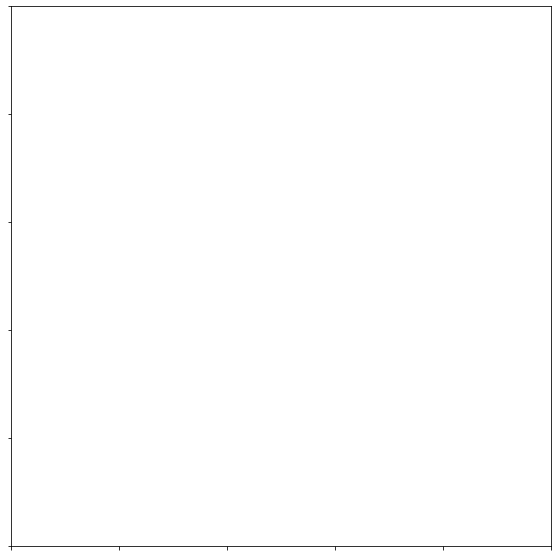

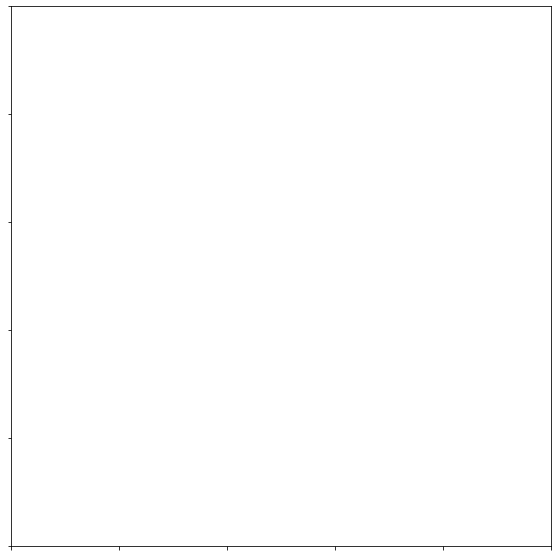

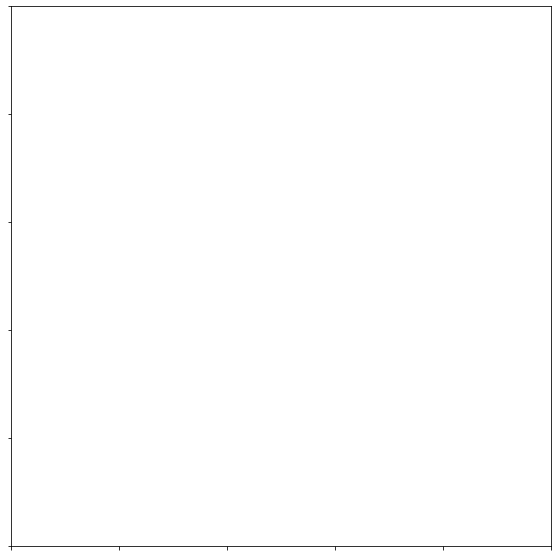

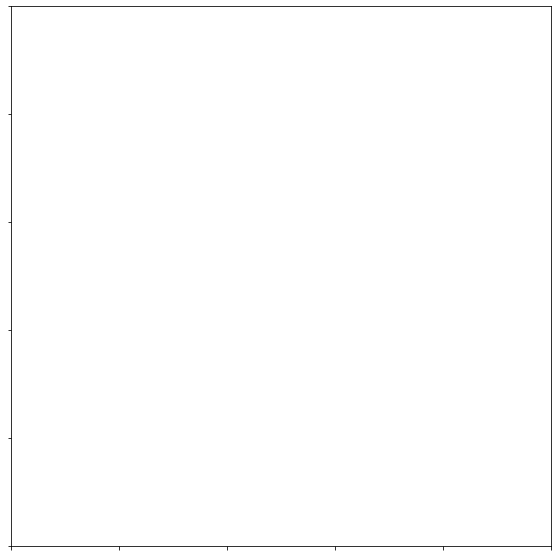

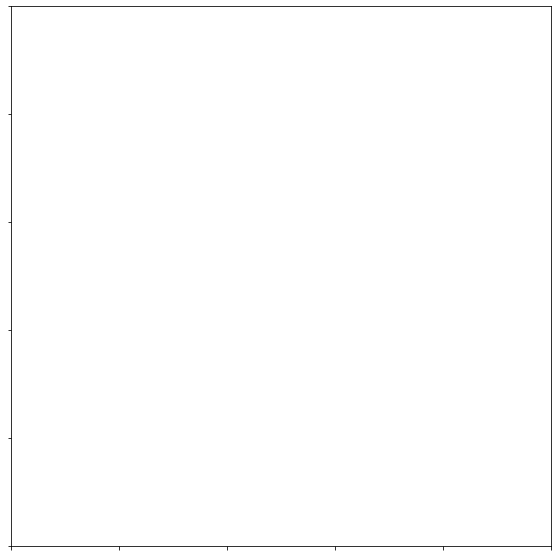

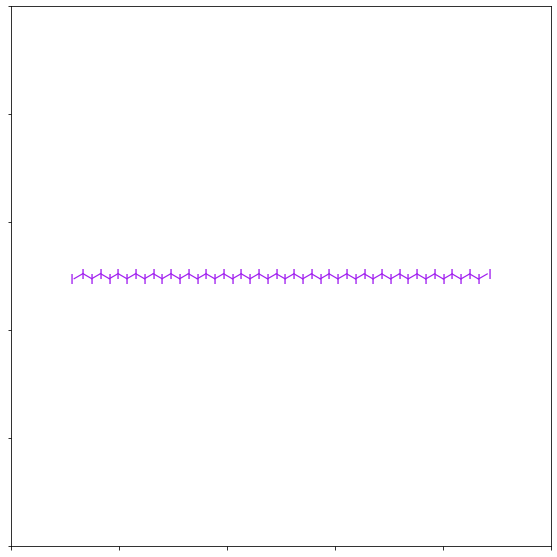

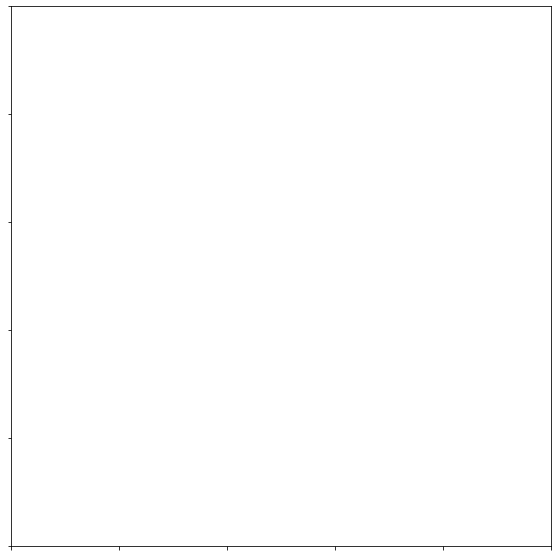

In [0]:
  # https://denouden.dev/VAE-Latent-Space-Explorer/
  
  import random

  # grid_x = np.linspace(-4, 4, num_samples)
  # grid_y = np.linspace(-4, 4, num_samples)[::-1]
  # for i, yi in enumerate(grid_y):
  #     for j, xi in enumerate(grid_x):
  #         z_sample = np.array([[xi, yi]])
  #         x_decoded = Decoder.predict(z_sample)
  #         # digit = x_decoded[0].reshape(img_width, img_height, num_channels)
  #         # figure[i * img_width: (i + 1) * img_width,
  #                 # j * img_height: (j + 1) * img_height] = digit
  # plt.figure(figsize=(10, 10))
  # start_range = img_width // 2
  # end_range = num_samples * img_width + start_range + 1
  # pixel_range = np.arange(start_range, end_range, img_width)
  # sample_range_x = np.round(grid_x, 1)
  # sample_range_y = np.round(grid_y, 1)
  # plt.xticks(pixel_range, sample_range_x)
  # plt.yticks(pixel_range, sample_range_y)
  # plt.xlabel('z - dim 1')
  # plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  # fig_shape = np.shape(figure)
  # if fig_shape[2] == 1:
  #   figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # # Show image
  # plt.imshow(figure)
  # plt.show()
  
  count = 0
  attempts = 30000
  for i in range(attempts):
    num_samples = 15
    # figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    z_sample = np.array([np.random.normal(size=256, loc=0, scale=random.random())])
    x_decoded = Decoder.predict(z_sample)
    
    # print(x_decoded.shape)
    smile  = outToSMILES(x_decoded[0])
    smile = smile.replace("_", "")
    mole1 = Chem.MolFromSmiles(smile)
    

    if mole1 and len(smile) != len("CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC"):
      print(smile)
      Draw.MolToMPL(mole1)
      count+=1
print(count, 'valid molecules found. Frac valid = ',count/attempts)

In [0]:
print(x.shape)

(40000, 256)


In [0]:
# visualize latent space using TSNE
datrunc = x[0:20000]
tsne = manifold.TSNE(n_components=2,perplexity=40, random_state=0)
X_tsne = tsne.fit_transform(datrunc)


KeyboardInterrupt: ignored

In [0]:
with open('drive/My Drive/drugVAE/tsne_data.pickle', 'wb') as handle:
    pickle.dump(X_tsne, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
import pickle
# logp_qeds = pd.read_csv("drive/My Drive/drugVAE/moses_new.csv")
filename = 'drive/My Drive/drugVAE/moses_new.csv'
logp_qeds = pd.read_csv(filename)
logp_qeds = logp_qeds[0:40000]

In [0]:
num_samples = 15
grid_x = np.linspace(-4, 4, num_samples)
grid_y = np.linspace(-4, 4, num_samples)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        smiles = outToSMILES(x_decoded)
        # digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        # figure[i * img_width: (i + 1) * img_width,
                # j * img_height: (j + 1) * img_height] = digit

In [0]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

fig=plt.figure(figsize=(16, 16), dpi= 50, facecolor='w', edgecolor='k')

sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=logp_qeds.cQED[0:20000], cmap=cm) # show druglikeness
# sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data.validMolecule[0:10000], cmap=cm) # show valid molecules
# plt.xticks([])
# plt.yticks([])

# plt.xlim(-4,4)
# plt.ylim(-4,4)
# im = plt.contourf(x,y,Z)

cb_ax = fig.add_axes([.91,.124,.04,.754])
fig.colorbar(sc,orientation='vertical',cax=cb_ax)

plt.show()
fig.savefig("drive/My Drive/drugVAE/tsne.png")

In [0]:
fig.savefig("drive/My Drive/drugVAE/tsne.png")

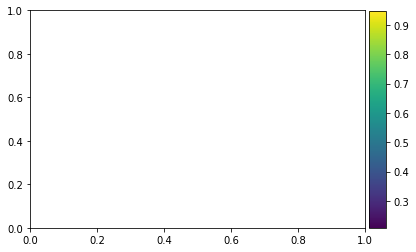

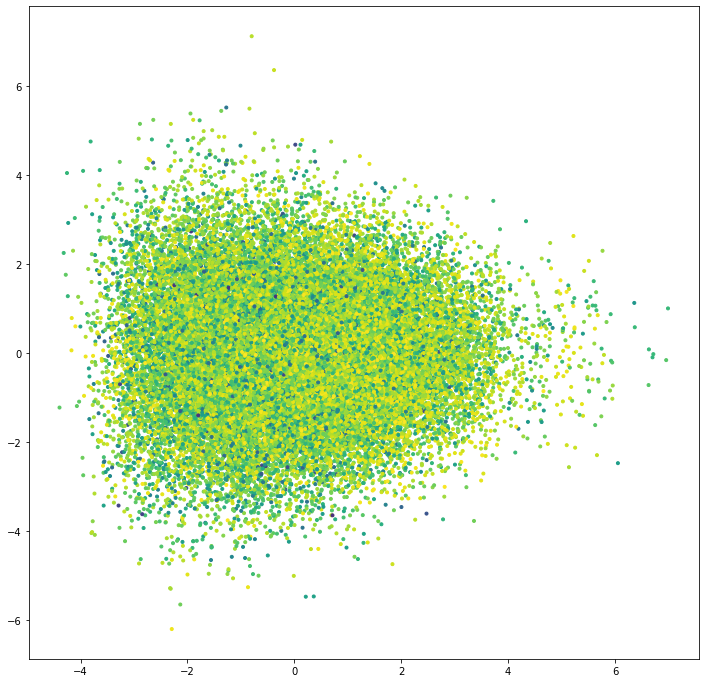

In [0]:
# PCA

from sklearn.decomposition import PCA

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')


pca = PCA(n_components = 2)
x_pca = pca.fit_transform(x)

plt.figure(figsize=(12, 12))

sc = plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='.', c=logp_qeds.cQED[0:40000])
cb_ax = fig.add_axes([.91,.124,.04,.754])
fig.colorbar(sc,orientation='vertical',cax=cb_ax)

plt.show()

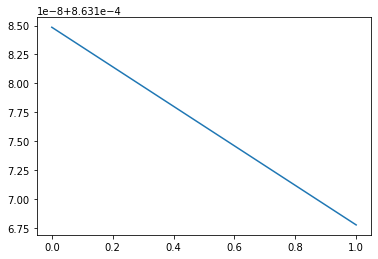

In [0]:
# Plot loss

#plt.matshow(smiles_onehot[5].T)
# plt.yscale("log")
plt.plot(h.history["loss"], label="Loss")
# plt.yscale("log")